In [22]:
from contextual_bandit import ContextualBandit
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Fusion_Model import FusionModel, CLIP_Model


Load dataset as tensors: X_train = concatenation of employee + company embedding

In [3]:
X_train, y_train = torch.load('data/X_train_simple.pt'), torch.load('data/y_train.pt')
X_train.shape, y_train.shape

(torch.Size([29273, 64]), torch.Size([29273]))

In [162]:
def get_PCA(feats, n=2):
    mean_feats = np.mean(feats, axis = 0)
    centered_feats = feats - mean_feats
    my_pca = PCA(n)
    new_feats = my_pca.fit_transform(centered_feats)
    return new_feats


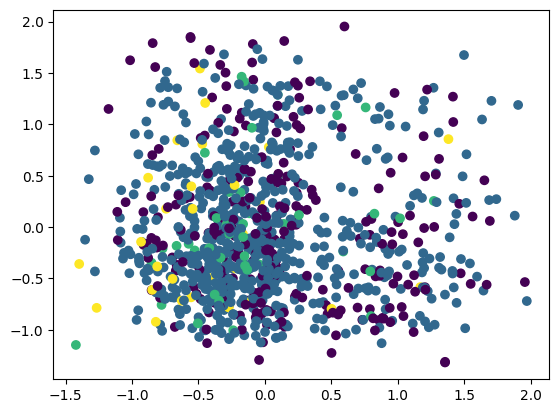

In [151]:
employee_feats = X_train
employee_PCA = get_PCA(employee_feats)
reduced_employee = employee_PCA[:1000, :]
plt.scatter(reduced_employee[:, 0], reduced_employee[:, 1], c = y_train[:1000])

### CLIP Experiments

In [6]:
import torch.nn.functional as F

def CLIP_loss(logits):
    n = logits.shape[1]      # number of samples
    labels = torch.arange(n) # Create labels tensor
    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")
    # Calculate the final loss
    loss = (loss_i + loss_t) / 2
    return loss

In [7]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train,y_train)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
from CenterLoss import CenterLoss

center_loss = CenterLoss(4, 64)

In [9]:

def train_CLIP(dataloader, num_epochs, lr=0.001, model = None):
    if model is None:
        model = FusionModel(32, 32, [64, 128, 32], [64, 32])
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    # clip_weight, center_weight = 0, 1
    loss_per_epoch = []
    # clip_losses, center_losses = [], []
    for _ in tqdm(range(num_epochs)):
        running_loss = []
        for batch in dataloader:
            X, y = batch[0], batch[1]
            emb1, emb2 = X[:, :32], X[:, 32:]
            optimizer.zero_grad()
            logits, new_emb1, new_emb2 = model(emb1, emb2)
            # joint_emb = torch.concat((new_emb1, new_emb2), dim = 1)
            # clip_loss_per_epoch, center_loss_per_epoch = CLIP_loss(logits)
            loss = CLIP_loss(logits)
            # loss = center_loss(y, joint_emb)
            # clip_losses.append(clip_loss_per_epoch)
            # center_losses.append(center_loss_per_epoch)
            # loss = (clip_weight * clip_loss_per_epoch) + (center_weight * center_loss_per_epoch)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
        mean_per_epoch = np.mean(running_loss)
        loss_per_epoch.append(mean_per_epoch)
    return model, loss_per_epoch # clip_losses, center_losses

In [41]:
model, losses = train_CLIP(dataloader, 200, lr = 1e-2)

100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


In [55]:
torch.save(model.state_dict(), 'CLIP_MLP.pth')

In [4]:
y_CLIP = torch.load('data/y_train.pt')

In [5]:
CLIP_MLP = CLIP_Model(32, 32, [64, 128, 32], [64, 32], 'MLP')
CLIP_MLP.load_state_dict(torch.load('CLIP_MLP.pth'))

<All keys matched successfully>

In [6]:
CLIP_MLP.eval()

CLIP_Model(
  (text1): MLP(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
  )
  (text2): MLP(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
  )
)

In [19]:
from contextual_bandit import ContextualBandit
import random

bandit = ContextualBandit(4, 64)
X_CLIP1, X_ClIP2 = CLIP_MLP.get_emb(X_train[:, :32], X_train[:, 32:])
X_CLIP = torch.concat((X_CLIP1, X_ClIP2), dim=1)

eps = 0.5
step = (1-0.2)/2000

chosen_arms = []
for t in tqdm(range(100)):
    for i in range(X_CLIP.shape[0]):
        if t < 5:
            eps = 1
        else:
            eps = max(0.2, eps-step)
        if random.random() < eps:
            arm = random.choice(range(4))
        else:
            context = X_CLIP[i, :]
            arm = bandit.select_arm(context)
        bandit.update(arm, y_CLIP[i])
        chosen_arms.append(arm)

pd.Series(chosen_arms).value_counts()

100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


1    2399258
2     176346
3     176206
0     175490
Name: count, dtype: int64

### 

In [20]:
predictions = []

for i in range(X_CLIP.shape[0]):
    context = X_CLIP[i, :]
    predictions.append(bandit.select_arm(context))

In [21]:
pd.Series(predictions).value_counts()

1    29273
Name: count, dtype: int64

In [15]:
sum(np.array(predictions) == np.array(y_CLIP))/len(y_CLIP)

0.5338366412735285

In [16]:
f1_score(y_CLIP, predictions, average = 'macro')

0.2243457286910827

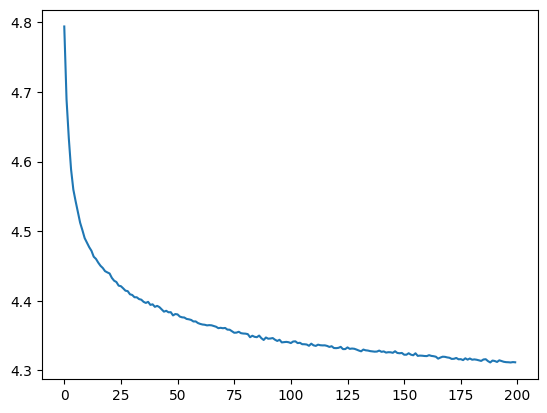

In [54]:
plt.plot(losses)

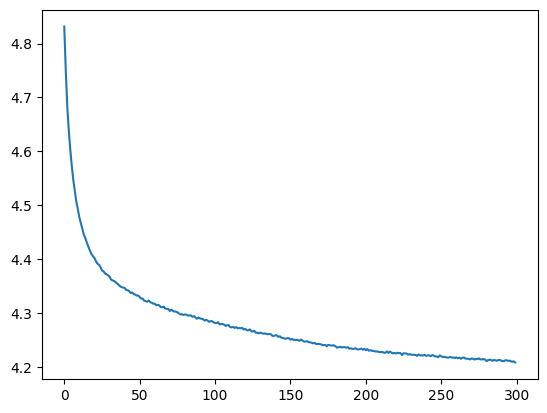

In [40]:
plt.plot(losses)

In [24]:
clip_losses = [a.item() for a in clip_losses]
center_losses = [a.item() for a in center_losses]

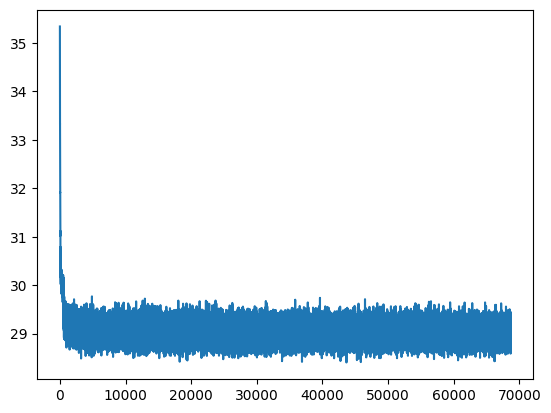

In [26]:
plt.plot(center_losses)

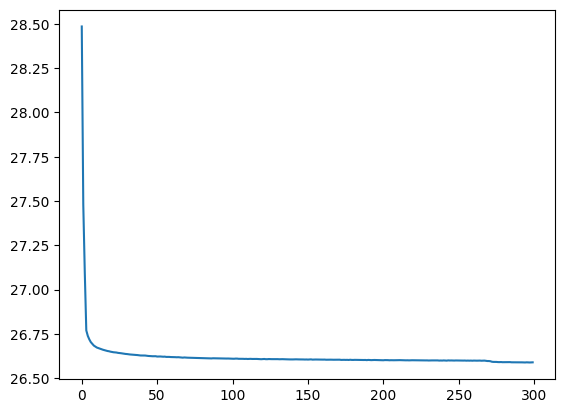

In [19]:
plt.plot(losses)

### Multi-armed Bandit

In [3]:
bandit, chosen_arms = thompson_sampling(X_train, y_train, 4, epsilon=0.1, num_epochs=1)

100%|██████████| 29273/29273 [00:09<00:00, 3092.57it/s]


In [4]:
pd.Series(chosen_arms).value_counts()

2    13949
3    13857
0      763
1      704
Name: count, dtype: int64

In [5]:
train_acc, chosen_arms_train = evaluate_bandit(X_train, y_train, bandit)
train_acc

tensor(0.3669)

### Test set evaluation

In [6]:
y_test_df = pd.read_csv('data/y_test.csv', index_col=0)
X_test, y_test = torch.load('data/X_test_simple.pt'), torch.load('data/y_test.pt')
decoding_map = ["Assistant", "Executive", "Manager", "Director"]
X_test.shape, y_test.shape

(torch.Size([7327, 64]), torch.Size([7327]))

In [7]:
test_acc, chosen_arms_test = evaluate_bandit(X_test, y_test, bandit)
test_acc

tensor(0.2518)

In [8]:
submission = pd.DataFrame()
submission['id'] = y_test_df['id']
positions = [decoding_map[arm] for arm in chosen_arms_test]
submission['position'] = positions
submission.head()

,id,position
0,29273,Executive
1,29274,Executive
2,29275,Executive
3,29276,Director
4,29277,Executive


In [9]:
# submission.to_csv('solutions/sub1.csv')

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train[:, :32], y_train)
clf.score(X_train[:, :32], y_train)

/Users/juliette/anaconda3/envs/compstat/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6209817920951047

In [68]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [75]:
X_resampled, y_resampled = torch.tensor(X_resampled), torch.tensor(y_resampled)

In [154]:
from Fusion_Model import FusionModel

def train_model(model, emb, y, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for _ in range(epochs):
        outputs = model(emb)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Final train loss:', loss.item())
    print('Final val loss: ', criterion(model(X_val), y_val).item())

In [158]:
fusion_model = FusionModel(64, 4)
train_model(fusion_model, X_train, y_train.long(), 10)

Final train loss: 0.9510192275047302
Final val loss:  0.9642956256866455


In [163]:
new_feats = fusion_model.get_emb(X_train).detach().numpy()
reduced_feats = get_PCA(new_feats)

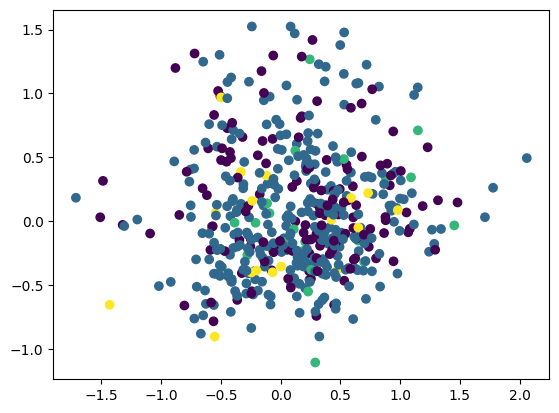

In [165]:
k = 500
reduced_feats_first = reduced_feats[:500, :]
plt.scatter(reduced_feats_first[:, 0], reduced_feats_first[:, 1], c = y_train[:500])

In [84]:
preds = fusion_model(X_test)
y_test = y_test.long()
torch.sum(torch.max(preds.detach(), 1).indices == y_test)/y_test.shape[0]

tensor(0.2518)

In [85]:
pd.Series(torch.max(preds.detach(), 1).indices).value_counts()

1    2021
0    1934
3    1890
2    1482
Name: count, dtype: int64

In [86]:
preds = torch.max(preds.detach(), 1).indices
f1_score(preds, y_test, average = 'macro')

0.25056800832830406

In [100]:
emb_Xtrain_resampled = fusion_model.get_emb(X_resampled)

In [101]:
bandit, chosen_arms = thompson_sampling(emb_Xtrain_resampled, y_resampled, 4, epsilon=0.2, num_epochs=5)

100%|██████████| 51360/51360 [01:14<00:00, 693.58it/s]


In [102]:
pd.Series(chosen_arms).value_counts()

1    218333
0     12901
2     12849
3     12717
Name: count, dtype: int64

In [103]:
emb_val = fusion_model.get_emb(X_val)

In [104]:
acc, chosen_arms_val = evaluate_bandit(emb_val, y_val, bandit)